<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#msticpy---Event-Clustering" data-toc-modified-id="msticpy---Event-Clustering-1">msticpy - Event Clustering</a></span></li><li><span><a href="#Processes-on-Host---Clustering" data-toc-modified-id="Processes-on-Host---Clustering-2">Processes on Host - Clustering</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Clustered-Processes-(i.e.-processes-that-have-a-cluster-size->-1)" data-toc-modified-id="Clustered-Processes-(i.e.-processes-that-have-a-cluster-size->-1)-2.0.0.1">Clustered Processes (i.e. processes that have a cluster size &gt; 1)</a></span></li></ul></li><li><span><a href="#Time-showing-clustered-vs.-original-data" data-toc-modified-id="Time-showing-clustered-vs.-original-data-2.0.1">Time showing clustered vs. original data</a></span></li></ul></li></ul></li><li><span><a href="#Host-Logons" data-toc-modified-id="Host-Logons-3">Host Logons</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Comparing-All-Logons-with-Clustered-results-relative-to-Alert-time-line" data-toc-modified-id="Comparing-All-Logons-with-Clustered-results-relative-to-Alert-time-line-3.0.1">Comparing All Logons with Clustered results relative to Alert time line</a></span></li><li><span><a href="#View-Process-Session-and-Logon-Events-in-Timelines" data-toc-modified-id="View-Process-Session-and-Logon-Events-in-Timelines-3.0.2">View Process Session and Logon Events in Timelines</a></span></li></ul></li><li><span><a href="#Get-Process-Tree" data-toc-modified-id="Get-Process-Tree-3.1">Get Process Tree</a></span></li></ul></li></ul></div>

# msticpy - Event Clustering

Often, large sets of events contain a lot of very repetitive and unintersting system processes. However, these frequently have values (e.g. commandline or path content) that varies on each execution. This makes it difficult to find outlying events using standard sorting and grouping techniques.
We process the data to extract patterns and use clustering to group these repetitive events into a single row (with an execution count). This makes it easier to find unusual events.

You must have msticpy installed with the "ml" components to run this notebook:
```
%pip install --upgrade msticpy[ml]
```



In [1]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Imports
import sys
import warnings

from msticpy.common.utility import check_py_version
MIN_REQ_PYTHON = (3,6)
check_py_version(MIN_REQ_PYTHON)

from IPython import get_ipython
from IPython.display import display
import ipywidgets as widgets

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import networkx as nx

import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 100)

import msticpy
msticpy.init_notebook(globals())
from msticpy.vis.timeline import display_timeline
from msticpy.vis import nbdisplay

# Some of our dependencies (networkx) still use deprecated Matplotlib
# APIs - we can't do anything about it so suppress them from view
from matplotlib import MatplotlibDeprecationWarning
warnings.simplefilter("ignore", category=MatplotlibDeprecationWarning)


<a id='process_clustering'></a>[Contents](#toc)
# Processes on Host - Clustering
Sometimes you don't have a source process to work with. Other times it's just useful to see what else is going on on the host. This section retrieves all processes on the host within the time bounds
set in the query times widget.

You can display the raw output of this by looking at the *processes_on_host* dataframe. Just copy this into a new cell and hit Ctrl-Enter.

Usually though, the results return a lot of very repetitive and unintersting system processes so we attempt to cluster these to make the view easier to negotiate. 
To do this we process the raw event list output to extract a few features that render strings (such as commandline)into numerical values. The default below uses the following features:
- commandLineTokensFull - this is a count of common delimiters in the commandline 
  (given by this regex r'[\s\-\\/\.,"\'|&:;%$()]'). The aim of this is to capture the commandline structure while ignoring variations on what is essentially the same pattern (e.g. temporary path GUIDs, target IP or host names, etc.)
- pathScore - this sums the ordinal (character) value of each character in the path (so /bin/bash and /bin/bosh would have similar scores).
- isSystemSession - 1 if this is a root/system session, 0 if anything else.

Then we run a clustering algorithm (DBScan in this case) on the process list. The result groups similar (noisy) processes together and leaves unique process patterns as single-member clusters.

#### Clustered Processes (i.e. processes that have a cluster size > 1)

Number of input events: 363
Number of clustered events: 62


<AxesSubplot:title={'center':'Process names with Cluster > 1'}, xlabel='processName'>

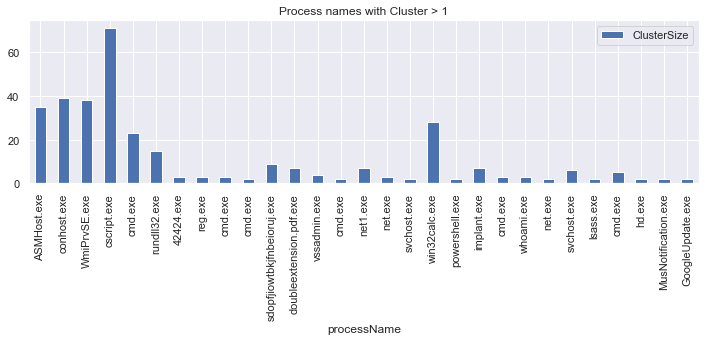

In [3]:
from msticpy.analysis.eventcluster import dbcluster_events, add_process_features

processes_on_host = pd.read_csv(
    "data/processes_on_host.csv",
    parse_dates=["TimeGenerated"],
    infer_datetime_format=True,
)

feature_procs = add_process_features(input_frame=processes_on_host)


# you might need to play around with the max_cluster_distance parameter.
# decreasing this gives more clusters.
(clus_events, dbcluster, x_data) = dbcluster_events(
    data=feature_procs,
    cluster_columns=["commandlineTokensFull", "pathScore", "isSystemSession"],
    time_column="TimeGenerated",
    max_cluster_distance=0.0001,
)
print("Number of input events:", len(feature_procs))
print("Number of clustered events:", len(clus_events))
clus_events[["ClusterSize", "processName"]][clus_events["ClusterSize"] > 1].plot.bar(
    x="processName", title="Process names with Cluster > 1", figsize=(12, 3)
)



Text(1, 1, 'Variability of Path')

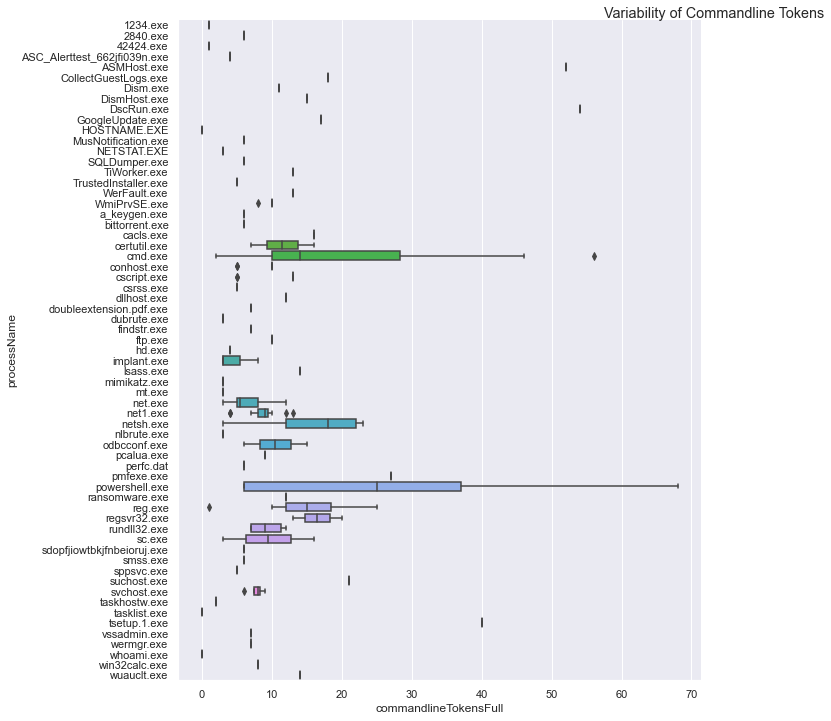

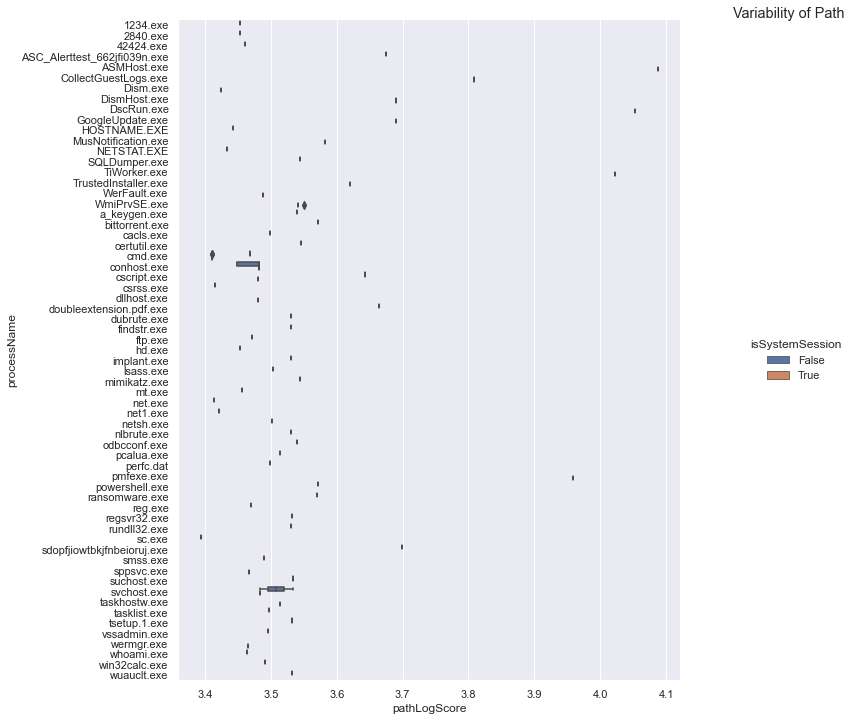

In [4]:
# Looking at the variability of commandlines and process image paths
import seaborn as sns

sns.set(style="darkgrid")

proc_plot = sns.catplot(
    y="processName",
    x="commandlineTokensFull",
    data=feature_procs.sort_values("processName"),
    kind="box",
    height=10,
)
proc_plot.fig.suptitle("Variability of Commandline Tokens", x=1, y=1)

proc_plot = sns.catplot(
    y="processName",
    x="pathLogScore",
    data=feature_procs.sort_values("processName"),
    kind="box",
    height=10,
    hue="isSystemSession",
)
proc_plot.fig.suptitle("Variability of Path", x=1, y=1)



The top graph shows that, for a given process, some have a wide variability in their command line content while the majority have little or none. Looking at a couple of examples - like cmd.exe, powershell.exe, reg.exe, net.exe - we can recognize several common command line tools.

The second graph shows processes by full process path content. We wouldn't normally expect to see variation here - as is the cast with most. There is also quite a lot of variance in the score making it a useful proxy feature for unique path name (this means that proc1.exe and proc2.exe that have the same commandline score won't get collapsed into the same cluster).

Any process with a spread of values here means that we are seeing the same process name (but not necessarily the same file) is being run from different locations.

In [5]:
display(
    clus_events.sort_values("ClusterSize")[
        [
            "TimeGenerated",
            "LastEventTime",
            "NewProcessName",
            "CommandLine",
            "ClusterSize",
            "commandlineTokensFull",
            "pathScore",
            "isSystemSession",
        ]
    ]
)



,TimeGenerated,LastEventTime,NewProcessName,CommandLine,ClusterSize,commandlineTokensFull,pathScore,isSystemSession
46,2019-01-15 04:23:43.103,2019-01-15 05:15:20.623,C:\Diagnostics\UserTmp\reg.exe,.\reg not /domain:everything that /sid:shines is /krbtgt:golden !,1,16,2951,False
356,2019-01-15 04:23:43.103,2019-01-15 05:15:20.623,C:\Program Files\Microsoft Monitoring Agent\Agent\Health Service State\Resources\222\pmfexe.exe,"""C:\Program Files\Microsoft Monitoring Agent\Agent\Health Service State\Resources\222\pmfexe.exe...",1,27,9108,True
301,2019-01-15 04:23:43.103,2019-01-15 05:15:20.623,C:\Windows\System32\cmd.exe,"""cmd""",1,2,2570,True
256,2019-01-15 04:23:43.103,2019-01-15 05:15:20.623,C:\WindowsAzure\GuestAgent_2.7.41491.901_2019-01-14_202614\CollectGuestLogs.exe,"""CollectGuestLogs.exe"" -Mode:ga -FileName:C:\WindowsAzure\CollectGuestLogsTemp\710dc858-9c96-4df...",1,18,6421,True
219,2019-01-15 04:23:43.103,2019-01-15 05:15:20.623,C:\Windows\System32\wermgr.exe,C:\Windows\system32\wermgr.exe -upload,1,7,2922,True
198,2019-01-15 04:23:43.103,2019-01-15 05:15:20.623,C:\Diagnostics\UserTmp\cmd.exe,"cmd /c echo "" SYSTEMINFO && SYSTEMINFO && DEL """,1,17,2941,False
195,2019-01-15 04:23:43.103,2019-01-15 05:15:20.623,C:\Diagnostics\UserTmp\cmd.exe,"cmd /c ""cd /d ""C:\inetpub\wwwroot""&c:\windows\system32\inetsrv\appcmd set config ""Default Web S...",1,39,2941,False
176,2019-01-15 04:23:43.103,2019-01-15 05:15:20.623,C:\Diagnostics\UserTmp\wuauclt.exe,".\wuauclt.exe /C ""c:\windows\softwaredistribution\cscript.exe""",1,14,3406,False
171,2019-01-15 04:23:43.103,2019-01-15 05:15:20.623,C:\Windows\System32\svchost.exe,c:\Windows\System32\svchost.exe -k malicious,1,9,3040,False
163,2019-01-15 04:23:43.103,2019-01-15 05:15:20.623,C:\Diagnostics\UserTmp\netsh.exe,.\netsh advfirewall firewall add rule name=RbtGskQ action=allow program=c:\users\Bob\appdata\Ro...,1,18,3179,False


In [6]:
# Look at clusters for individual process names
def view_cluster(exe_name):
    display(
        clus_events[["ClusterSize", "processName", "CommandLine", "ClusterId"]][
            clus_events["processName"] == exe_name
        ]
    )


view_cluster("reg.exe")



,ClusterSize,processName,CommandLine,ClusterId
46,1,reg.exe,.\reg not /domain:everything that /sid:shines is /krbtgt:golden !,-1
56,3,reg.exe,.\reg.exe add \hkcu\software\microsoft\some\key\Run /v abadvalue,7


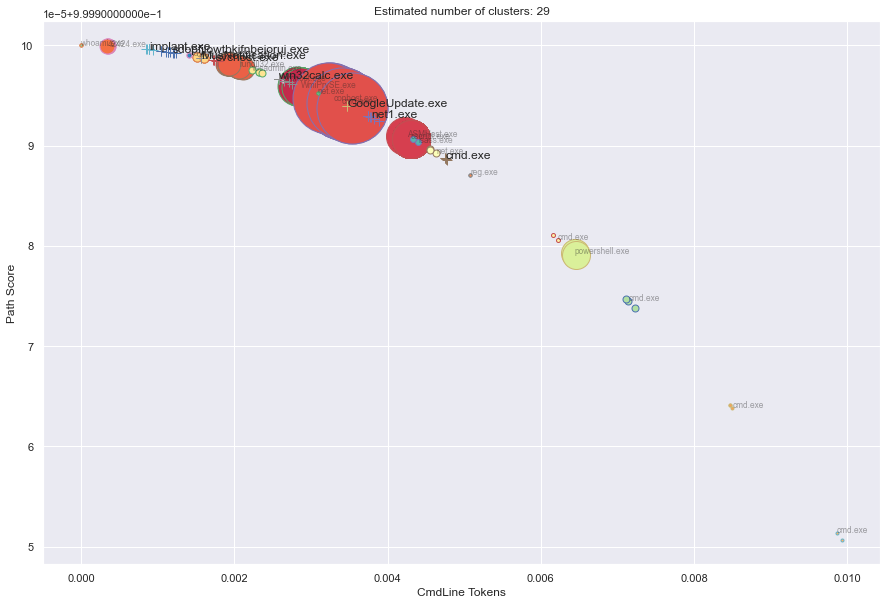

<module 'matplotlib.pyplot' from 'F:\\anaconda\\envs\\msticpy\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [7]:
# Show all clustered processes
from msticpy.analysis.eventcluster import plot_cluster

# Create label with unqualified path
labelled_df = processes_on_host.copy()
labelled_df["label"] = labelled_df.apply(
    lambda x: x.NewProcessName.split("\\")[-1], axis=1
)

%matplotlib inline
#%matplotlib notebook
plt.rcParams["figure.figsize"] = (15, 10)
plot_cluster(
    dbcluster,
    labelled_df,
    x_data,
    plot_label="label",
    plot_features=[0, 1],
    verbose=False,
    cut_off=3,
    xlabel="CmdLine Tokens",
    ylabel="Path Score",
)


### Time showing clustered vs. original data

In [8]:
# Show timeline of events - clustered events

clus_events.mp_plot.timeline(
    # overlay_data=processes_on_host,
    title="Distinct Host Processes (bottom) and All Proceses (top)"
)


Loading BokehJS ...

Column(id='1075', ...)

<a id='host_logons'></a>[Contents](#toc)
# Host Logons


Since the number of logon events may be large and, in the case of system logons, very repetitive, we use clustering to try to identity logons with unique characteristics.

In this case we use the numeric score of the account name and the logon type (i.e. interactive, service, etc.). The results of the clustered logons are shown below along with a more detailed, readable printout of the logon event information. The data here will vary depending on whether this is a Windows or Linux host.

In [9]:
from msticpy.analysis.eventcluster import (
    dbcluster_events,
    add_process_features,
    char_ord_score,
)

host_logons = pd.read_csv(
    "data/host_logons.csv", parse_dates=["TimeGenerated"], infer_datetime_format=True
)
logon_features = host_logons.copy()
logon_features["AccountNum"] = host_logons.apply(
    lambda x: char_ord_score(x.Account), axis=1
)
logon_features["LogonHour"] = host_logons.apply(lambda x: x.TimeGenerated.hour, axis=1)

# you might need to play around with the max_cluster_distance parameter.
# decreasing this gives more clusters.
(clus_logons, _, _) = dbcluster_events(
    data=logon_features,
    time_column="TimeGenerated",
    cluster_columns=["AccountNum", "LogonType"],
    max_cluster_distance=0.0001,
)
print("Number of input events:", len(host_logons))
print("Number of clustered events:", len(clus_logons))
print("\nDistinct host logon patterns:")
display(clus_logons.sort_values("TimeGenerated"))


Number of input events: 14
Number of clustered events: 3

Distinct host logon patterns:


,Unnamed: 0,TenantId,Account,EventID,TimeGenerated,SourceComputerId,Computer,SubjectUserName,SubjectDomainName,SubjectUserSid,TargetUserName,TargetDomainName,TargetUserSid,TargetLogonId,LogonProcessName,LogonType,AuthenticationPackageName,Status,IpAddress,WorkstationName,AccountNum,LogonHour,Clustered,ClusterId,ClusterSize,FirstEventTime,LastEventTime
1,1,802d39e1-9d70-404d-832c-2de5e2478eda,NT AUTHORITY\SYSTEM,4624,2019-01-15 01:42:28.340,46fe7078-61bb-4bed-9430-7ac01d91c273,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,SYSTEM,NT AUTHORITY,S-1-5-18,0x3e7,Advapi,5,Negotiate,NaN,-,-,1484,5,True,1,11,2019-01-15 01:42:28.340,2019-01-15 05:15:14.453
0,0,802d39e1-9d70-404d-832c-2de5e2478eda,MSTICAlertsWin1\MSTICAdmin,4624,2019-01-15 04:28:33.090,46fe7078-61bb-4bed-9430-7ac01d91c273,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,MSTICAdmin,MSTICAlertsWin1,S-1-5-21-996632719-2361334927-4038480536-500,0xfaac27,Advapi,4,Negotiate,NaN,-,MSTICAlertsWin1,2319,5,True,0,2,2019-01-15 04:28:33.090,2019-01-15 05:15:02.980
2,2,802d39e1-9d70-404d-832c-2de5e2478eda,MSTICAlertsWin1\adm1nistrator,4624,2019-01-15 05:15:06.363,46fe7078-61bb-4bed-9430-7ac01d91c273,MSTICAlertsWin1,-,-,S-1-0-0,adm1nistrator,MSTICAlertsWin1,S-1-5-21-996632719-2361334927-4038480536-1066,0xfb5ee6,NtLmSsp,3,NTLM,NaN,fe80::38dc:e4a9:61bd:b458,MSTICAlertsWin1,2799,5,False,-1,1,2019-01-15 05:15:06.363,2019-01-15 05:15:06.363


In [10]:
# Display logon details
nbdisplay.display_logon_data(clus_logons)

Account: adm1nistratorAccount Domain: MSTICAlertsWin1Logon Time: 2019-01-15 05:15:06.363000Logon type: 3(Network)User Id/SID: S-1-5-21-996632719-2361334927-4038480536-1066 SID S-1-5-21-996632719-2361334927-4038480536-1066 is local machine or domain accountSubject (source) account: -/-Logon process: NtLmSsp Authentication: NTLMSource IpAddress: fe80::38dc:e4a9:61bd:b458Source Host: MSTICAlertsWin1Logon status: nan
Account: MSTICAdminAccount Domain: MSTICAlertsWin1Logon Time: 2019-01-15 04:28:33.090000Logon type: 4(Batch)User Id/SID: S-1-5-21-996632719-2361334927-4038480536-500 SID S-1-5-21-996632719-2361334927-4038480536-500 is administrator SID S-1-5-21-996632719-2361334927-4038480536-500 is local machine or domain accountSubject (source) account: WORKGROUP/MSTICAlertsWin1$Logon process: Advapi Authentication: NegotiateSource IpAddress: -Source Host: MSTICAlertsWin1Logon status: nan
Account: SYSTEMAccount Domain: NT AUTHORITYLogon Time: 2019-01-15 01:42:28.340000Logon type: 5(Service)User Id/SID: S-1-5-18 SID S-1-5-18 is LOCAL_SYSTEMSubject (source) account: WORKGROUP/MSTICAlertsWin1$Logon process: Advapi Authentication: NegotiateSource IpAddress: -Source Host: -Logon status: nan


### Comparing All Logons with Clustered results relative to Alert time line

In [11]:
clus_logons

,Unnamed: 0,TenantId,Account,EventID,TimeGenerated,SourceComputerId,Computer,SubjectUserName,SubjectDomainName,SubjectUserSid,TargetUserName,TargetDomainName,TargetUserSid,TargetLogonId,LogonProcessName,LogonType,AuthenticationPackageName,Status,IpAddress,WorkstationName,AccountNum,LogonHour,Clustered,ClusterId,ClusterSize,FirstEventTime,LastEventTime
2,2,802d39e1-9d70-404d-832c-2de5e2478eda,MSTICAlertsWin1\adm1nistrator,4624,2019-01-15 05:15:06.363,46fe7078-61bb-4bed-9430-7ac01d91c273,MSTICAlertsWin1,-,-,S-1-0-0,adm1nistrator,MSTICAlertsWin1,S-1-5-21-996632719-2361334927-4038480536-1066,0xfb5ee6,NtLmSsp,3,NTLM,NaN,fe80::38dc:e4a9:61bd:b458,MSTICAlertsWin1,2799,5,False,-1,1,2019-01-15 05:15:06.363,2019-01-15 05:15:06.363
0,0,802d39e1-9d70-404d-832c-2de5e2478eda,MSTICAlertsWin1\MSTICAdmin,4624,2019-01-15 04:28:33.090,46fe7078-61bb-4bed-9430-7ac01d91c273,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,MSTICAdmin,MSTICAlertsWin1,S-1-5-21-996632719-2361334927-4038480536-500,0xfaac27,Advapi,4,Negotiate,NaN,-,MSTICAlertsWin1,2319,5,True,0,2,2019-01-15 04:28:33.090,2019-01-15 05:15:02.980
1,1,802d39e1-9d70-404d-832c-2de5e2478eda,NT AUTHORITY\SYSTEM,4624,2019-01-15 01:42:28.340,46fe7078-61bb-4bed-9430-7ac01d91c273,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,SYSTEM,NT AUTHORITY,S-1-5-18,0x3e7,Advapi,5,Negotiate,NaN,-,-,1484,5,True,1,11,2019-01-15 01:42:28.340,2019-01-15 05:15:14.453


In [12]:
# Show timeline of events - all logons + clustered logons
# ref marker indicates

logon_data = {"Clustered": {"data": clus_logons}, "All Logons": {"data": host_logons}}
display_timeline(
    data=logon_data,
    source_columns=["Account", "LogonType"],
    ref_event=clus_logons.iloc[0],
    title="All Host Logons",
    legend="inline",
)



Loading BokehJS ...

Column(id='1440', ...)

### View Process Session and Logon Events in Timelines
This shows the timeline of the clustered logon events with the process tree obtained earlier. This allows you to get a sense of which logon was responsible for the process tree session whether any additional logons (e.g. creating a process as another user) might be associated with the alert timeline.

*Note you should use the pan and zoom tools to align the timelines since the data may be over different time ranges.*

In [13]:
# Show timeline of events - all events
display_timeline(data=clus_logons,
                           source_columns=['Account', 'LogonType'],
                           title='Clustered Host Logons', height=200)
process_tree = pd.read_csv('data/process_tree.csv',
                           parse_dates=["TimeGenerated"],
                           infer_datetime_format=True)
display_timeline(data=process_tree,
                           title='Alert Process Session', height=200)

Loading BokehJS ...

Loading BokehJS ...

Column(id='2058', ...)

In [14]:
display_timeline(data=clus_logons, group_by="Account",
                           source_columns=['Account', 'LogonType'],
                           title='Clustered Host Logons',
                           legend="right",
                           yaxis=True)

Loading BokehJS ...

Column(id='2386', ...)

In [15]:
# Counts of Logon types by Account
host_logons[['Account', 'LogonType', 'TimeGenerated']].groupby(['Account','LogonType']).count()

,,TimeGenerated
Account,LogonType,
MSTICAlertsWin1\MSTICAdmin,4,2
MSTICAlertsWin1\adm1nistrator,3,1
NT AUTHORITY\SYSTEM,5,11
